In [1]:
import os
import geopandas as gpd
from water_quality.tiling import get_aoi_tiles
from water_quality.instruments import check_instrument_dates
from water_quality.load_data import build_dc_queries, build_wq_dataset
from odc.geo.geom import Geometry
from water_quality.water_detection import water_analysis
from water_quality.pixel_corrections import R_correction
from water_quality.hue import hue_calculation
from water_quality.logs import setup_logging
from water_quality.instruments import get_instruments_list
from water_quality.optical_water_type import OWT_pixel
from water_quality.wq_algorithms import WQ_vars, ALGORITHMS_CHLA, ALGORITHMS_TSM

In [2]:
%load_ext memory_profiler

In [3]:
%load_ext autoreload
%autoreload 2
# To automatically reload modules when they change:

In [4]:
test_data_dir = "../tests/data"

In [5]:
# Analysis parameters:
# The area of interest run over.
place_name = "SA_smalldam"
# Time range to run the analysis over
start_date = "2023"
end_date = "2024"
# Set a list of 'instruments' to be used in the analysis
instruments_to_use = {
    'oli_agm'  : {'use': True },
    'oli'      : {'use': False},
    'msi_agm'  : {'use': True },
    'msi'      : {'use': False},
    'tm_agm'   : {'use': True },
    'tm'       : {'use': False},
    'tirs'     : {'use': False},  
    'wofs_ann' : {'use': True },
    'wofs_all' : {'use': True },  # wofs_all will be removed as it is better to derive from wofs_ann
    }
WFTH = water_frequency_threshold_high = 0.5    #this threshold targets areas that are as like as not to be water at any time.
WFTL = water_frequency_threshold_low  = 0.1    #for pixel processing (rather than during summation)
PWT  = permanent_water_threshold      = 0.875  #used to map annual permanent water (value arrived at through testing)
SC   = sigma_coefficient              = 1.2    #used to map annual permanent water (value arrived at through tessting)

In [6]:
log = setup_logging()

In [7]:
# Load area of interests 
places_fp =  os.path.join("../tests/data", "places.parquet")
places = gpd.read_parquet(places_fp)

# Select extract an AOI for a given placenam.
place = places[places["name"].isin([place_name])]
place

,name,run,desc,geometry
30,SA_smalldam,True,"Irrigation Dam, South Africa","POLYGON ((19.498 -33.802, 19.498 -33.8, 19.494..."


In [8]:
# Get the tiles covering the area of interest chosen
place_geom = Geometry(geom=place.iloc[0].geometry, crs=place.crs)
tiles = get_aoi_tiles(place_geom)
tiles = list(tiles)
tiles

[((601, 103),
  GeoBox((3200, 3200), Affine(10.0, 0.0, 1856000.0,
         0.0, -10.0, -4064000.0), CRS('EPSG:6933')))]

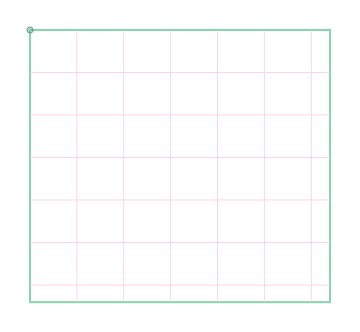

In [9]:
# Select a single tile to test continental processing over
tile = tiles[0]
tile_idx = tile[0]
tile_geobox = tile[1]

# Make tile geobox smaller
#from odc.geo.geobox import GeoBox
#tile_geobox = GeoBox.from_geopolygon(place_geom, tile_geobox.resolution, tile_geobox.crs)

tile_geobox

In [10]:
print(tile_geobox)

GeoBox((3200, 3200), Affine(10.0, 0.0, 1856000.0,
       0.0, -10.0, -4064000.0), CRS('EPSG:6933'))


In [11]:
# --- don't try to use instruments for which there are no data 
instruments_to_use = check_instrument_dates(instruments_to_use, start_date, end_date)
instruments_to_use

2025-06-10 23:19:23,227 water_quality.instruments [ERROR]: Instrument tm_agm has the date ranges 1990-01-01 to 2012-12-31 which is outside the supplied date range of 2023-01-01 to 2024-12-31.


{'oli_agm': {'use': True},
 'oli': {'use': False},
 'msi_agm': {'use': True},
 'msi': {'use': False},
 'tm_agm': {'use': False},
 'tm': {'use': False},
 'tirs': {'use': False},
 'wofs_ann': {'use': True},
 'wofs_all': {'use': True}}

In [12]:
instruments_list = get_instruments_list(instruments_to_use)
instruments_list

{'oli_agm': {'SR_B2': {'varname': 'oli02_agm',
   'parameters': (True, '450-510')},
  'SR_B3': {'varname': 'oli03_agm', 'parameters': (True, '530-590')},
  'SR_B4': {'varname': 'oli04_agm', 'parameters': (True, '640-670')},
  'SR_B5': {'varname': 'oli05_agm', 'parameters': (True, '850-880')},
  'SR_B6': {'varname': 'oli06_agm', 'parameters': (True, '1570-1650')},
  'SR_B7': {'varname': 'oli07_agm', 'parameters': (True, '2110-2290')},
  'smad': {'varname': 'oli_agm_smad', 'parameters': (True,)},
  'count': {'varname': 'oli_agm_count', 'parameters': (True,)}},
 'msi_agm': {'B02': {'varname': 'msi02_agm', 'parameters': (True, '460-525')},
  'B03': {'varname': 'msi03_agm', 'parameters': (True,)},
  'B04': {'varname': 'msi04_agm', 'parameters': (True,)},
  'B05': {'varname': 'msi05_agm', 'parameters': (True,)},
  'B06': {'varname': 'msi06_agm', 'parameters': (True,)},
  'B07': {'varname': 'msi07_agm', 'parameters': (True,)},
  'B12': {'varname': 'msi12_agm',
   'parameters': (True,
    'uin

In [13]:
%%memit
# --- build the multivariate/multi-sensor dataset. 
dc_queries = build_dc_queries(instruments_to_use, tile_geobox, start_date, end_date)
ds = build_wq_dataset(dc_queries)
print(ds)

<xarray.Dataset> Size: 1GB
Dimensions:              (time: 2, y: 3200, x: 3200)
Coordinates:
  * time                 (time) datetime64[ns] 16B 2023-07-02T11:59:59.999999...
  * y                    (y) float64 26kB -4.064e+06 -4.064e+06 ... -4.096e+06
  * x                    (x) float64 26kB 1.856e+06 1.856e+06 ... 1.888e+06
    spatial_ref          int32 4B 6933
Data variables: (12/23)
    oli02_agm            (time, y, x) uint16 41MB 184 170 156 ... 209 204 199
    oli03_agm            (time, y, x) uint16 41MB 386 370 355 ... 364 357 349
    oli04_agm            (time, y, x) uint16 41MB 407 374 342 ... 403 393 383
    oli05_agm            (time, y, x) uint16 41MB 2111 2169 2227 ... 1324 1294
    oli06_agm            (time, y, x) uint16 41MB 1426 1325 1225 ... 1324 1292
    oli07_agm            (time, y, x) uint16 41MB 802 714 626 ... 813 794 775
    ...                   ...
    wofs_ann_freq        (time, y, x) float32 82MB nan nan nan ... nan nan nan
    wofs_ann_clearcount  (tim

In [14]:
%%memit
# Determine pixels that are water (sometimes, usually, permanent)
ds = water_analysis(ds,
           water_frequency_threshold= WFTH,
           wofs_varname             = 'wofs_ann_freq',
           permanent_water_threshold= PWT,
           sigma_coefficient        = SC,)

print(ds)

/opt/venv/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:236: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


<xarray.Dataset> Size: 1GB
Dimensions:              (time: 2, y: 3200, x: 3200)
Coordinates:
  * time                 (time) datetime64[ns] 16B 2023-07-02T11:59:59.999999...
  * y                    (y) float64 26kB -4.064e+06 -4.064e+06 ... -4.096e+06
  * x                    (x) float64 26kB 1.856e+06 1.856e+06 ... 1.888e+06
    spatial_ref          int32 4B 6933
Data variables: (12/29)
    oli02_agm            (time, y, x) uint16 41MB 184 170 156 ... 209 204 199
    oli03_agm            (time, y, x) uint16 41MB 386 370 355 ... 364 357 349
    oli04_agm            (time, y, x) uint16 41MB 407 374 342 ... 403 393 383
    oli05_agm            (time, y, x) uint16 41MB 2111 2169 2227 ... 1324 1294
    oli06_agm            (time, y, x) uint16 41MB 1426 1325 1225 ... 1324 1292
    oli07_agm            (time, y, x) uint16 41MB 802 714 626 ... 813 794 775
    ...                   ...
    wofs_ann_freq_sigma  (time, y, x) float32 82MB nan nan nan ... nan nan nan
    wofs_ann_confidence  (tim

In [15]:
%%memit
dp_adjust = { 
        'msi_agm': {'ref_var':'msi12_agm','var_list': ['msi04_agm','msi03_agm','msi02_agm','msi05_agm','msi06_agm', 'msi07_agm']},
        'oli_agm': {'ref_var':'oli07_agm','var_list': ['oli04_agm','oli03_agm','oli02_agm']},
        # 'tm_agm' : {'ref_var':'tm07_agm', 'var_list': ['tm04_agm','tm03_agm','tm02_agm','tm01_agm']}
        }
ds = R_correction(ds,dp_adjust,instruments_to_use,water_frequency_threshold_low)
print(ds)

2025-06-10 23:19:57,788 water_quality.pixel_corrections [INFO]: Performing dark pixel correction for sensor msi_agm ...
2025-06-10 23:19:58,994 water_quality.pixel_corrections [INFO]: Performing dark pixel correction for sensor oli_agm ...
<xarray.Dataset> Size: 2GB
Dimensions:              (time: 2, y: 3200, x: 3200)
Coordinates:
  * time                 (time) datetime64[ns] 16B 2023-07-02T11:59:59.999999...
  * y                    (y) float64 26kB -4.064e+06 -4.064e+06 ... -4.096e+06
  * x                    (x) float64 26kB 1.856e+06 1.856e+06 ... 1.888e+06
    spatial_ref          int32 4B 6933
Data variables: (12/38)
    oli02_agm            (time, y, x) uint16 41MB 184 170 156 ... 209 204 199
    oli03_agm            (time, y, x) uint16 41MB 386 370 355 ... 364 357 349
    oli04_agm            (time, y, x) uint16 41MB 407 374 342 ... 403 393 383
    oli05_agm            (time, y, x) uint16 41MB 2111 2169 2227 ... 1324 1294
    oli06_agm            (time, y, x) uint16 41MB 1426 

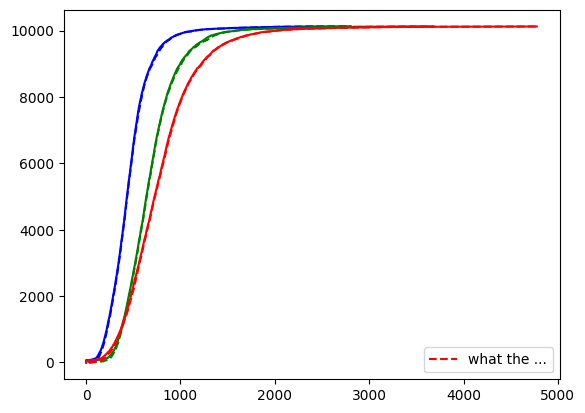

In [16]:
import numpy as np
import matplotlib.pyplot as plt

y = np.random.rand(np.size(ds.msi02_agm))  #creates a random field with the right number of values..
target_n = 10000
if np.size(y) > target_n: 
    rand_cut = target_n/np.size(y)
else: 
    rand_cut = 1
effective_n = np.size(y[np.argwhere(y<rand_cut)])

if True:
    x = np.arange(0,effective_n)
    plt.plot(np.sort(ds['msi02_agmr'].values.reshape(np.size(ds['msi02_agmr'])))[np.argwhere(y<rand_cut)],x,"b-")
    plt.plot(np.sort(ds['msi02_agm' ].values.reshape(np.size(ds['msi02_agm' ])))[np.argwhere(y<rand_cut)],x,"b--" )
    plt.plot(np.sort(ds['msi03_agmr'].values.reshape(np.size(ds['msi02_agm'])))[np.argwhere(y<rand_cut)],x,"g-")
    plt.plot(np.sort(ds['msi03_agm'].values.reshape(np.size(ds['msi02_agm'])))[np.argwhere(y<rand_cut)],x,"g--")
    plt.plot(np.sort(ds['msi04_agmr'].values.reshape(np.size(ds['msi02_agm'])))[np.argwhere(y<rand_cut)],x,"r-")
    plt.plot(np.sort(ds['msi04_agm'].values.reshape(np.size(ds['msi02_agm'])))[np.argwhere(y<rand_cut)],x,"r--",label='what the ...')

plt.legend()
plt.show()

In [17]:
%%memit
ds['hue'] = hue_calculation(ds,instrument='msi_agm')
print(ds)

2025-06-10 23:20:07,139 water_quality.hue [INFO]: Average Hue values pre-adjustment : [59.  63.1]
2025-06-10 23:20:08,627 water_quality.hue [INFO]: Average Hue values post-ajustment : [52.  58.9]
<xarray.Dataset> Size: 2GB
Dimensions:              (time: 2, y: 3200, x: 3200)
Coordinates:
  * time                 (time) datetime64[ns] 16B 2023-07-02T11:59:59.999999...
  * y                    (y) float64 26kB -4.064e+06 -4.064e+06 ... -4.096e+06
  * x                    (x) float64 26kB 1.856e+06 1.856e+06 ... 1.888e+06
    spatial_ref          int32 4B 6933
Data variables: (12/39)
    oli02_agm            (time, y, x) uint16 41MB 184 170 156 ... 209 204 199
    oli03_agm            (time, y, x) uint16 41MB 386 370 355 ... 364 357 349
    oli04_agm            (time, y, x) uint16 41MB 407 374 342 ... 403 393 383
    oli05_agm            (time, y, x) uint16 41MB 2111 2169 2227 ... 1324 1294
    oli06_agm            (time, y, x) uint16 41MB 1426 1325 1225 ... 1324 1292
    oli07_agm       

In [18]:
%%memit
instrument = 'msi_agm'
ds['owt_msi']  = OWT_pixel(ds, instrument)
print(ds)

<xarray.Dataset> Size: 3GB
Dimensions:              (time: 2, y: 3200, x: 3200)
Coordinates:
  * time                 (time) datetime64[ns] 16B 2023-07-02T11:59:59.999999...
  * y                    (y) float64 26kB -4.064e+06 -4.064e+06 ... -4.096e+06
  * x                    (x) float64 26kB 1.856e+06 1.856e+06 ... 1.888e+06
    spatial_ref          int32 4B 6933
Data variables: (12/40)
    oli02_agm            (time, y, x) uint16 41MB 184 170 156 ... 209 204 199
    oli03_agm            (time, y, x) uint16 41MB 386 370 355 ... 364 357 349
    oli04_agm            (time, y, x) uint16 41MB 407 374 342 ... 403 393 383
    oli05_agm            (time, y, x) uint16 41MB 2111 2169 2227 ... 1324 1294
    oli06_agm            (time, y, x) uint16 41MB 1426 1325 1225 ... 1324 1292
    oli07_agm            (time, y, x) uint16 41MB 802 714 626 ... 813 794 775
    ...                   ...
    msi07_agmr           (time, y, x) float32 82MB 1.972e+03 ... 1.669e+03
    oli04_agmr           (time, y

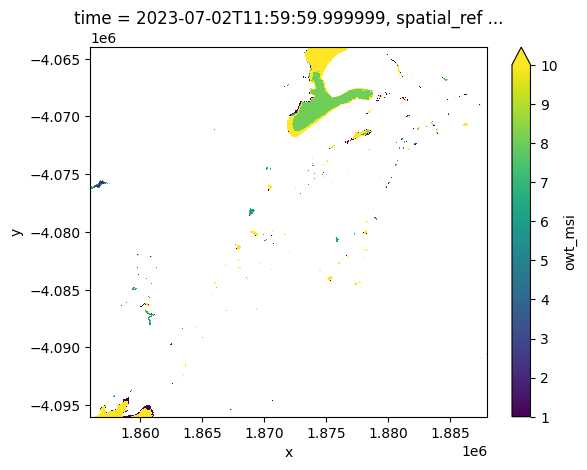

In [19]:
ds['owt_msi'].isel(time=0).plot(vmin=1, vmax=10)

In [20]:
%%memit
# ---- Apply the WQ algorithms to water areas, adding variables to the dataset and building  a list of water quality variable nanmes
# -- this can be run either keeping the wq variables as separate variables on the dataset, or by moving them into new dimensions, 'tss' and 'chla'
# -- If the arguments 'new_dimension_name' or 'new_varname' are None (or empty), then the outputs will be retained as separate variables in a 3d dataset

if True: #put the data into a new dimension, call the variable 'tss' or 'chla'
    ds,tsm_vlist  = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms= ALGORITHMS_TSM,  
                        instruments_list=instruments_list, 
                        new_dimension_name='tss_measure', 
                        new_varname='tss', 
                        )
    ds,chla_vlist = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms= ALGORITHMS_CHLA,  
                        instruments_list=instruments_list, 
                        new_dimension_name='chla_measure', 
                        new_varname='chla',)
else:  #keep it simple, just add new data as new variables in a 3-D dataset 
    ds,tsm_vlist  = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms= ALGORITHMS_TSM,  
                        instruments_list=instruments_list, 
                        new_dimension_name=None, 
                        new_varname=None, )
    ds,chla_vlist = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms= ALGORITHMS_CHLA,  
                        instruments_list=instruments_list, 
                        new_dimension_name=None, 
                        new_varname=None)
wq_varlist = np.append(tsm_vlist,chla_vlist)

2025-06-10 23:20:26,529 water_quality.wq_algorithms [INFO]: Running  WQ algorithms for: ndssi_rg, ndssi_bnir, ti_yu, tsm_lym, tss_zhang, spm_qiu
2025-06-10 23:20:26,530 water_quality.wq_algorithms [INFO]: Running  WQ algorithm ndssi_rg
2025-06-10 23:20:26,531 water_quality.wq_algorithms [INFO]: Instrument: msi_agm
2025-06-10 23:20:26,531 water_quality.wq_algorithms [INFO]: NDSSI_RG
2025-06-10 23:20:26,635 water_quality.wq_algorithms [INFO]: Instrument: oli_agm
2025-06-10 23:20:26,635 water_quality.wq_algorithms [INFO]: NDSSI_RG
2025-06-10 23:20:26,739 water_quality.wq_algorithms [INFO]: Running  WQ algorithm ndssi_bnir
2025-06-10 23:20:26,740 water_quality.wq_algorithms [INFO]: Instrument: oli_agm
2025-06-10 23:20:26,740 water_quality.wq_algorithms [INFO]: NDSSI_BNIR
2025-06-10 23:20:26,845 water_quality.wq_algorithms [INFO]: Running  WQ algorithm ti_yu
2025-06-10 23:20:26,846 water_quality.wq_algorithms [INFO]: Instrument: oli_agm
2025-06-10 23:20:26,847 water_quality.wq_algorithms [I

In [21]:
ds

<xarray.Dataset> Size: 6GB
Dimensions:              (time: 2, y: 3200, x: 3200, tss_measure: 10,
                          chla_measure: 6)
Coordinates:
  * time                 (time) datetime64[ns] 16B 2023-07-02T11:59:59.999999...
  * y                    (y) float64 26kB -4.064e+06 -4.064e+06 ... -4.096e+06
  * x                    (x) float64 26kB 1.856e+06 1.856e+06 ... 1.888e+06
    spatial_ref          int32 4B 6933
  * tss_measure          (tss_measure) <U18 720B 'ndssi_rg_msi_agm' ... 'spm_...
  * chla_measure         (chla_measure) <U20 480B 'ndci_msi54_agm' ... 'chla_...
Data variables: (12/42)
    oli02_agm            (time, y, x) float32 82MB nan nan nan ... nan nan nan
    oli03_agm            (time, y, x) float32 82MB nan nan nan ... nan nan nan
    oli04_agm            (time, y, x) float32 82MB nan nan nan ... nan nan nan
    oli05_agm            (time, y, x) float32 82MB nan nan nan ... nan nan nan
    oli06_agm            (time, y, x) float32 82MB nan nan nan ... nan nan nan
    oli07_agm            (time, y, x) float32 82MB nan nan nan ... nan nan nan
    ...                   ...
    oli03_agmr           (time, y, x) float32 82MB nan nan nan ... nan nan nan
    oli02_agmr           (time, y, x) float32 82MB nan nan nan ... nan nan nan
    hue                  (time, y, x) float64 164MB nan nan nan ... nan nan nan
    owt_msi              (time, y, x) float64 164MB nan nan nan ... nan nan nan
    tss                  (time, y, x, tss_measure) float64 2GB nan nan ... nan
    chla                 (time, y, x, chla_measure) float64 983MB nan ... nan
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

In [22]:
# ---- tidy up by dropping excess variables ---
keeplist = ('wofs_ann_clearcount','wofs_ann_wetcount','wofs_ann_freq','wofs_ann_freq_sigma','wofs_pw_threshold','wofs_ann_pwater','watermask','owt_msi','tss','chla')
#the keeplist is not complete; if the wq variables are retained as variables they will appear in a listing of data_vars. 
#therefore, revert to the instruments dictionary to list variables to drop
droplist = []
for instrument in list(instruments_list.keys()):
    for band in list(instruments_list[instrument].keys()):
        variable = instruments_list[instrument][band]['varname']
        if not (variable in keeplist): 
            droplist=np.append(droplist,variable)
            droplist=np.append(droplist,variable+'r')
for varname in droplist:
    if varname in ds.data_vars:
        ds = ds.drop_vars(varname)

In [23]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:              (time: 2, y: 3200, x: 3200, tss_measure: 10,
                          chla_measure: 6)
Coordinates:
  * time                 (time) datetime64[ns] 16B 2023-07-02T11:59:59.999999...
  * y                    (y) float64 26kB -4.064e+06 -4.064e+06 ... -4.096e+06
  * x                    (x) float64 26kB 1.856e+06 1.856e+06 ... 1.888e+06
    spatial_ref          int32 4B 6933
  * tss_measure          (tss_measure) <U18 720B 'ndssi_rg_msi_agm' ... 'spm_...
  * chla_measure         (chla_measure) <U20 480B 'ndci_msi54_agm' ... 'chla_...
Data variables: (12/13)
    wofs_ann_freq        (time, y, x) float32 82MB nan nan nan ... nan nan nan
    wofs_ann_clearcount  (time, y, x) float32 82MB nan nan nan ... nan nan nan
    wofs_ann_wetcount    (time, y, x) float32 82MB nan nan nan ... nan nan nan
    wofs_ann_freq_sigma  (time, y, x) float32 82MB nan nan nan ... nan nan nan
    wofs_ann_confidence  (time, y, x) float32 82MB nan nan nan ... nan nan nan
    wofs_pw_threshold    (time, y, x) float32 82MB nan nan nan ... nan nan nan
    ...                   ...
    wofs_ann_water       (time, y, x) float32 82MB nan nan nan ... nan nan nan
    watermask            (time, y, x) float32 82MB nan nan nan ... nan nan nan
    hue                  (time, y, x) float64 164MB nan nan nan ... nan nan nan
    owt_msi              (time, y, x) float64 164MB nan nan nan ... nan nan nan
    tss                  (time, y, x, tss_measure) float64 2GB nan nan ... nan
    chla                 (time, y, x, chla_measure) float64 983MB nan ... nan
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

In [24]:
#export the dataset as an input for the next step:
ds.to_netcdf("../WP1.3/wp13_ds.nc")

In [25]:
ds.data_vars

Data variables:
    wofs_ann_freq        (time, y, x) float32 82MB nan nan nan ... nan nan nan
    wofs_ann_clearcount  (time, y, x) float32 82MB nan nan nan ... nan nan nan
    wofs_ann_wetcount    (time, y, x) float32 82MB nan nan nan ... nan nan nan
    wofs_ann_freq_sigma  (time, y, x) float32 82MB nan nan nan ... nan nan nan
    wofs_ann_confidence  (time, y, x) float32 82MB nan nan nan ... nan nan nan
    wofs_pw_threshold    (time, y, x) float32 82MB nan nan nan ... nan nan nan
    wofs_ann_pwater      (time, y, x) float32 82MB nan nan nan ... nan nan nan
    wofs_ann_water       (time, y, x) float32 82MB nan nan nan ... nan nan nan
    watermask            (time, y, x) float32 82MB nan nan nan ... nan nan nan
    hue                  (time, y, x) float64 164MB nan nan nan ... nan nan nan
    owt_msi              (time, y, x) float64 164MB nan nan nan ... nan nan nan
    tss                  (time, y, x, tss_measure) float64 2GB nan nan ... nan
    chla                 (time, y,

In [26]:
ds['wofs_ann_confidence'] = ((1.0 - (ds.wofs_ann_freq_sigma/ds.wofs_ann_freq)) * 100).astype('int16')

/opt/venv/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:236: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


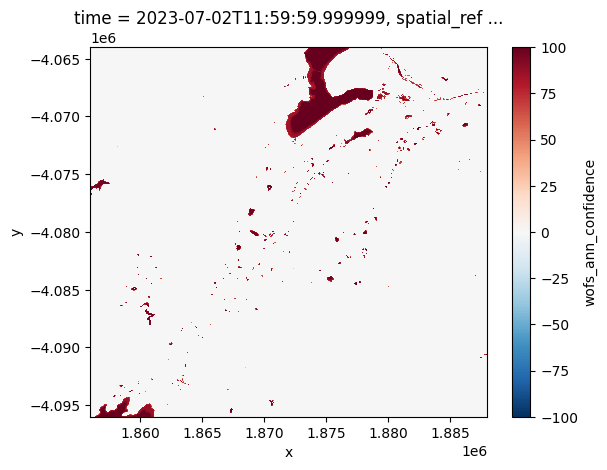

In [27]:
ds.isel(time=0).wofs_ann_confidence.plot()